In [ ]:
#from google.colab import files
#uploaded = files.upload()

Saving global_power_plant_database.csv to global_power_plant_database.csv


In [23]:
# !pip install geopy
# !pip install geopandas

In [ ]:
# from geopy.geocoders import Nominatim
# import time
# geolocator = Nominatim(user_agent="myGeocoder")
# location = geolocator.geocode('Honolulu,  HI')
# (location.latitude, location.longitude)

(21.304547, -157.8556764)

In [14]:
# manual parsing for some MSA
cache = {'Augusta, GA':(-81.966667, 33.466667), 'Birmingham, AL':(-86.779633, 33.543682), 'Denver, CO': (-104.991531, 39.742043)}

In [15]:
cache

{'Augusta, GA': (-81.966667, 33.466667),
 'Birmingham, AL': (-86.779633, 33.543682),
 'Denver, CO': (-104.991531, 39.742043)}

In [23]:
import time
from geopy.geocoders import Nominatim
import geopandas
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

geolocator = Nominatim(user_agent="myGeocoder")

def convert_to_lat(loc):
  if loc in cache:
    return cache[loc][1]
  else:
    location = geolocator.geocode(loc)
    time.sleep(0.5)
    cache[loc] = (location.longitude, location.latitude)
    return cache[loc][1]

def convert_to_long(loc):
  if loc in cache:
    return cache[loc][0]
  else:
    location = geolocator.geocode(loc)
    time.sleep(0.5)
    cache[loc] = (location.longitude, location.latitude)
    return cache[loc][0]
  

In [17]:
df = pd.read_csv('United States and Puerto Rico Cancer Statistics, 1999-2017 Incidence.txt', delimiter='\t')

In [18]:
df.drop(['Notes', 'MSA Code'], axis=1, inplace=True)
df = df.dropna()

In [19]:
df = df[df['MSA'] != 'Other']
# Does not consider Haiwai
df = df[~df['MSA'].isin(['Honolulu, HI', 'Urban Honolulu, HI'])]
df = df[df['Crude Rate'] != 'Not Applicable']
def parse_loc(loc):
  city, state = loc.split(',')
  return city.split('-')[0].strip()+", "+state.split('-')[0].strip()
df['MSA'] = df['MSA'].apply(parse_loc)
df['MSA'].replace({'Winston, NC': 'Winston-Salem, NC'}, inplace=True)

In [25]:
df['latitude'] = df['MSA'].apply(convert_to_lat)
df['longitude'] = df['MSA'].apply(convert_to_long)

In [26]:
df

,MSA,Sex,Sex Code,Race,Race Code,Year,Year Code,Leading Cancer Sites,Leading Cancer Sites Code,Count,Population,Crude Rate,latitude,longitude
0,"Akron, OH",Female,F,White,2106-3,1999.0,1999.0,Brain and Other Nervous System,31010-31040,17.0,310511,5.5,41.083064,-81.518485
1,"Akron, OH",Female,F,White,2106-3,2000.0,2000.0,Brain and Other Nervous System,31010-31040,26.0,310857,8.4,41.083064,-81.518485
2,"Akron, OH",Female,F,White,2106-3,2001.0,2001.0,Brain and Other Nervous System,31010-31040,17.0,310845,5.5,41.083064,-81.518485
3,"Akron, OH",Female,F,White,2106-3,2002.0,2002.0,Brain and Other Nervous System,31010-31040,24.0,310777,7.7,41.083064,-81.518485
4,"Akron, OH",Female,F,White,2106-3,2003.0,2003.0,Brain and Other Nervous System,31010-31040,22.0,310310,7.1,41.083064,-81.518485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933,"Youngstown, OH",Male,M,White,2106-3,2013.0,2013.0,Brain and Other Nervous System,31010-31040,26.0,236173,11.0,41.103579,-80.652016
3934,"Youngstown, OH",Male,M,White,2106-3,2014.0,2014.0,Brain and Other Nervous System,31010-31040,23.0,235027,9.8,41.103579,-80.652016
3935,"Youngstown, OH",Male,M,White,2106-3,2015.0,2015.0,Brain and Other Nervous System,31010-31040,31.0,233088,13.3,41.103579,-80.652016
3936,"Youngstown, OH",Male,M,White,2106-3,2016.0,2016.0,Brain and Other Nervous System,31010-31040,26.0,231337,11.2,41.103579,-80.652016


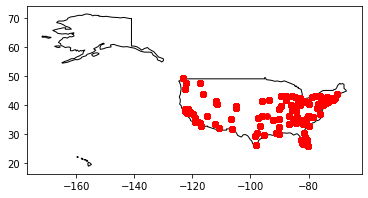

In [27]:
df = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'United States of America'].plot(
    color='white', edgecolor='black')
df.plot(ax=ax, color='red')
plt.show()

In [29]:
pdf = pd.read_csv('global_power_plant_database.csv')
pdf = pdf[pdf['country'] == 'USA']
pdf = pdf[pdf['primary_fuel'] == 'Nuclear']

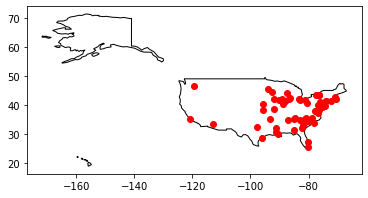

In [30]:
pdf = geopandas.GeoDataFrame(
    pdf, geometry=geopandas.points_from_xy(pdf.longitude, pdf.latitude))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name == 'United States of America'].plot(
    color='white', edgecolor='black')
pdf.plot(ax=ax, color='red')
plt.show()

In [31]:
# distance to closet nuclear power plant
from geopy.distance import distance, lonlat

dist_cache = {}
def get_shortest_distance(cur, plants):
  if cur in dist_cache:
    return dist_cache[cur]
  min_dist = min(map(lambda plant: distance(lonlat(*cur), lonlat(*plant)).miles, plants))
  dist_cache[cur] = min_dist
  return min_dist

In [32]:
power_plants_lonlat = list(zip(pdf.longitude, pdf.latitude))
df['min_dist'] = list(map(lambda x: get_shortest_distance(x, power_plants_lonlat), (zip(df.longitude, df.latitude))))
df['min_dist_squared'] = df['min_dist']**2

In [33]:
df

,MSA,Sex,Sex Code,Race,Race Code,Year,Year Code,Leading Cancer Sites,Leading Cancer Sites Code,Count,Population,Crude Rate,latitude,longitude,geometry,min_dist,min_dist_squared
0,"Akron, OH",Female,F,White,2106-3,1999.0,1999.0,Brain and Other Nervous System,31010-31040,17.0,310511,5.5,41.083064,-81.518485,POINT (-81.51848 41.08306),53.201224,2830.370286
1,"Akron, OH",Female,F,White,2106-3,2000.0,2000.0,Brain and Other Nervous System,31010-31040,26.0,310857,8.4,41.083064,-81.518485,POINT (-81.51848 41.08306),53.201224,2830.370286
2,"Akron, OH",Female,F,White,2106-3,2001.0,2001.0,Brain and Other Nervous System,31010-31040,17.0,310845,5.5,41.083064,-81.518485,POINT (-81.51848 41.08306),53.201224,2830.370286
3,"Akron, OH",Female,F,White,2106-3,2002.0,2002.0,Brain and Other Nervous System,31010-31040,24.0,310777,7.7,41.083064,-81.518485,POINT (-81.51848 41.08306),53.201224,2830.370286
4,"Akron, OH",Female,F,White,2106-3,2003.0,2003.0,Brain and Other Nervous System,31010-31040,22.0,310310,7.1,41.083064,-81.518485,POINT (-81.51848 41.08306),53.201224,2830.370286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933,"Youngstown, OH",Male,M,White,2106-3,2013.0,2013.0,Brain and Other Nervous System,31010-31040,26.0,236173,11.0,41.103579,-80.652016,POINT (-80.65202 41.10358),35.152136,1235.672662
3934,"Youngstown, OH",Male,M,White,2106-3,2014.0,2014.0,Brain and Other Nervous System,31010-31040,23.0,235027,9.8,41.103579,-80.652016,POINT (-80.65202 41.10358),35.152136,1235.672662
3935,"Youngstown, OH",Male,M,White,2106-3,2015.0,2015.0,Brain and Other Nervous System,31010-31040,31.0,233088,13.3,41.103579,-80.652016,POINT (-80.65202 41.10358),35.152136,1235.672662
3936,"Youngstown, OH",Male,M,White,2106-3,2016.0,2016.0,Brain and Other Nervous System,31010-31040,26.0,231337,11.2,41.103579,-80.652016,POINT (-80.65202 41.10358),35.152136,1235.672662


In [34]:
df['min_dist'].describe()

count    3926.000000
mean      110.256782
std       103.575954
min        11.705505
25%        38.597081
50%        78.073373
75%       144.657119
max       515.825788
Name: min_dist, dtype: float64

In [35]:
from scipy import stats
import statsmodels.api as sm

In [36]:
df['Crude Rate'] = df['Crude Rate'].astype(float)

In [37]:
X = sm.add_constant(df.loc[:, 'min_dist'])
est = sm.OLS(df['Crude Rate'], X)
est = est.fit(cov_type='HC1')
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             Crude Rate   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     53.66
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           2.87e-13
Time:                        00:36:10   Log-Likelihood:                -8671.3
No. Observations:                3926   AIC:                         1.735e+04
Df Residuals:                    3924   BIC:                         1.736e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.8195      0.051    154.070      0.0

In [38]:
X = sm.add_constant(df.loc[:, 'min_dist_squared'])
est = sm.OLS(df['Crude Rate'], X)
est = est.fit(cov_type='HC1')
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:             Crude Rate   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     47.70
Date:                Thu, 03 Dec 2020   Prob (F-statistic):           5.76e-12
Time:                        00:36:12   Log-Likelihood:                -8676.0
No. Observations:                3926   AIC:                         1.736e+04
Df Residuals:                    3924   BIC:                         1.737e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                7.6816      0.040  